In [1]:
from dotenv import load_dotenv
load_dotenv()
from typing import TypedDict,Annotated
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import  add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from IPython.display import display,Image


In [2]:
@tool
def get_stock_price(symbol: str) -> float:
    '''This function returns the stock price
    :param symbol : stock symbol
    :return: current price of stock
    '''

    return{
        "MSFT" :100.6,
        "AAPL" :250.5,
        "GOOG" :175.8,
        "AMZN" :123.0,
    }.get(symbol, 0.00)

tools= [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.5-flash")
llm_with_tools =llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list,add_messages]

def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

build = StateGraph(State)





E0000 00:00:1759852841.667032    7183 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


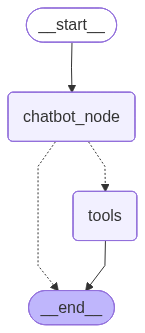

In [3]:
build.add_node("chatbot_node", chatbot)
build.add_node("tools",ToolNode(tools))

build.add_edge(START, "chatbot_node")
build.add_conditional_edges( "chatbot_node",tools_condition)
build.add_edge("chatbot_node", END)

app= build.compile()
display(app)

In [6]:
message ={"role":"user", "content":"what is the price of AMZN stock price  ?"}
output=app.invoke({"messages" : [message]})
print(output)

{'messages': [HumanMessage(content='what is the price of AMZN stock price  ?', additional_kwargs={}, response_metadata={}, id='a226da59-5528-4def-9727-2fd0ce32abb4'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--4634d380-5b43-470a-9dd5-f410fdd3f481-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '830fbee8-1f33-45ef-a08e-cb30d3f1ce9b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 69, 'output_tokens': 91, 'total_tokens': 160, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 73}}), ToolMessage(content='123.0', name='get_stock_price', id='9d2996a9-8137-45af-bc2c-533f4ca2ce38', tool_call_id='830fbee8-1f33-45ef-a08e-cb30d3f1ce9b')]}


In [11]:
state=app.invoke({"messages":[{"role":"user", "content":"what is the price of AAPL stockprice?"}]})
print(state["messages"][ -1].content)

250.5
